# Problem set 2 (40 + 36 + 35 = 111 pts)

In this problem set we also present some bonus problems that will be considered as in Problem Set 1.

## Problem 2. Deep image prior (36 pts)

In the deep prior framework, we aim to learn a prior distribution over the parameters $\theta$ of a generative model such that, given some observation $\hat{y}$, we can sample a plausible output $y$ from the learned prior distribution. The goal is to learn a posterior distribution $p(z,\theta|\hat{y})$ over the latent variable $z$ and the parameters $\theta$ such that, given some observation $\hat{y}$ (e.g., an image of a face), we can sample a plausible latent variable $z$ and generate a corresponding output image $y= f_\theta(z)$ that is similar to the observation. The conditional distribution of $y$ given $\hat{y}$ can be written as an integral over $z$ and $\theta$:

$$p(y|\hat{y}) = \int p(y|z,\theta,\hat{y})p(z,\theta|\hat{y})dzd\theta$$

Unfortunately, in practice, it is difficult to compute this integral exactly, since we don't know the conditional distribution $p(y|z,\theta,\hat{y})$ and the posterior distribution $p(z,\theta|\hat{y})$. Instead, we can use an optimization approach to learn the prior distribution $p(z,\theta)$ and the network $f_\theta(z)$ that best approximate the true conditional distribution.

Specifically, we first assume that the latent variable $z$ is independent of the observation $\hat{y}$, i.e., $p(z,\theta|\hat{y}) = p(\theta|\hat{y})p(z)$. This allows us to rewrite the conditional distribution of $y$ as:

$$p(y|\hat{y}) = \int p(y|z,\theta,\hat{y})p(\theta|\hat{y})p(z)dzd\theta$$

Next, we use an optimization approach to learn the parameters $\theta$ of the network to minimize the expected distance between the generated output $y=f_\theta(z)$ and the observation $\hat{y}$:

$$\min_\theta E(f_\theta(z),\hat{y})$$

To perform this optimization, we can apply a stochastic gradient descent approach where we sample random values of $z$ from the prior distribution $p(z)$ and compute the gradients of the loss function with respect to $\theta$ using backpropagation. This way, we can iteratively update the parameters of the network to improve its ability to generate realistic outputs given the observed data.

This approach is used to perform denoising, inpainting and super resolution. The basic architecture for the task is UNet, which we will use in our experiments.

## Implementation

In [2]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import torch
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torchvision
from torchvision import transforms
import gdown
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchmetrics import TotalVariation as TV

In [4]:
class Encoder_Block(torch.nn.Module):
    def __init__(self,inp_channels,out_channels):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(inp_channels,out_channels,kernel_size=3,padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
        )
        self.downsample = torch.nn.MaxPool2d(2)
    def forward(self,x):
        int_out = self.model(x)
        return self.downsample(int_out), int_out

class Decoder_Block(torch.nn.Module):
    def __init__(self,inp_channels,out_channels):
        super().__init__()
        self.upsample = torch.nn.ConvTranspose2d(inp_channels,out_channels,kernel_size=2,stride=2)
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(inp_channels,out_channels,kernel_size=3,padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
        )
    def forward(self,x,enc_x):
        x = self.upsample(x)
        x = torch.cat([x,enc_x],dim=1)
        return self.model(x)

In [5]:
class Unet(torch.nn.Module):
    def __init__(self,inc,outc,hidden_size=16):
        super().__init__()
        self.Encoder = torch.nn.ModuleList([
            Encoder_Block(inc,hidden_size),
            Encoder_Block(hidden_size,hidden_size*2),
            Encoder_Block(hidden_size*2,hidden_size*4),
            Encoder_Block(hidden_size*4,hidden_size*8),
        ])
        self.bottleneck = torch.nn.Sequential(
            torch.nn.Conv2d(hidden_size*8,hidden_size*16,kernel_size=1),
            torch.nn.BatchNorm2d(hidden_size*16),
            torch.nn.ReLU(),
            torch.nn.Conv2d(hidden_size*16,hidden_size*16,kernel_size=1),
            torch.nn.BatchNorm2d(hidden_size*16),
            torch.nn.ReLU()
        )
        self.Decoder = torch.nn.ModuleList([
            Decoder_Block(hidden_size*16,hidden_size*8),
            Decoder_Block(hidden_size*8,hidden_size*4),
            Decoder_Block(hidden_size*4,hidden_size*2),
            Decoder_Block(hidden_size*2,hidden_size*1),
        ])
        self.last_layer = torch.nn.Sequential(
            torch.nn.Conv2d(hidden_size,outc,kernel_size=3,padding="same"),
            torch.nn.Sigmoid()
        )
    def forward(self,x):
        enc_xs = []
        for module in self.Encoder:
            x, enc_x= module(x)
            enc_xs.append(enc_x)

        enc_xs = enc_xs[::-1]
        x = self.bottleneck(x)

        for i,module in enumerate(self.Decoder):
            x = module(x,enc_xs[i])
        return self.last_layer(x)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
sharing_link = "https://drive.google.com/file/d/1QMZ9_XdFRfj-arUvW_hlG5Mw8vjzTLsU/view?usp=share_link"
gdown.download(url=sharing_link, output="./data.zip", quiet=False, fuzzy=True)
!unzip ./data.zip

Downloading...
From: https://drive.google.com/uc?id=1QMZ9_XdFRfj-arUvW_hlG5Mw8vjzTLsU
To: /content/data.zip
100%|██████████| 1.60M/1.60M [00:00<00:00, 106MB/s]


Archive:  ./data.zip
replace data/denoising/F16_GT.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [9]:
img = transform(Image.open("./data/denoising/F16_GT.png"))[None].to(device)

## Your work starts here

In [10]:
noise_strength = 0.1
corrupted_img = (img + torch.randn_like(img)*noise_strength).clamp(0,1)

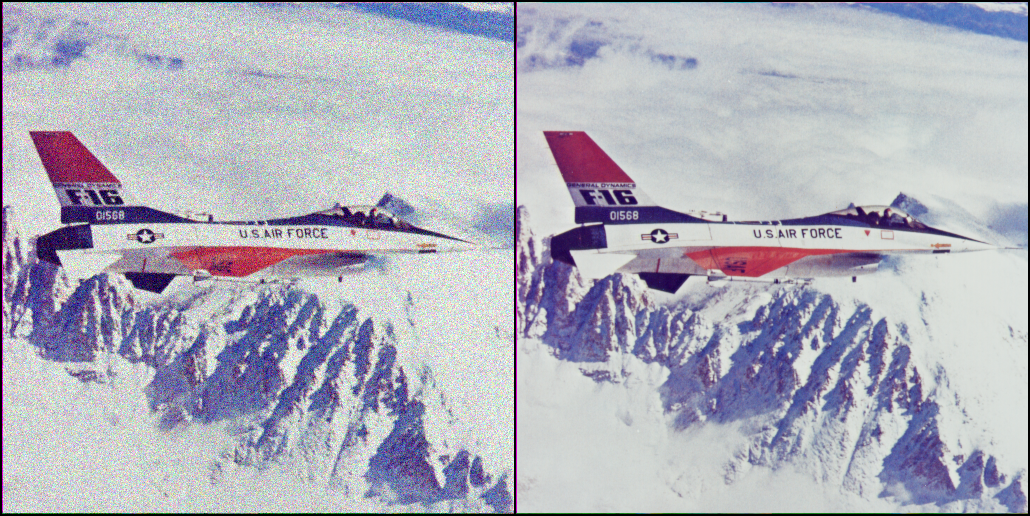

In [11]:
transforms.ToPILImage()(torchvision.utils.make_grid(torch.cat([corrupted_img,img],dim=0),nrow=2,normalize=True))

## Optimization (6 pts)

Task: Implement an optimization function that takes a model, input image, corrupted image, original image, and the number of iterations as arguments.

Steps:

1. Initialize an optimizer (Adam optimizer with learning rate $10^{-4}$).
2. Write a cycle for optimization using the specified loss function (criterion).
3. In each step of the cycle, add a certain amount of noise (reg_noise=0.01) to the input $z$ to ensure computational stability.

**We have provided baseline values for hyperparameters in this and future tasks, but feel free to make adjustments if needed.**

In [12]:
from tqdm import tqdm


In [ ]:
def optimization(model,z,corrupted_img,orig_img,iters,criterion=torch.nn.MSELoss(),reg_noise=0.01):
    # your code is here
    optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
    corrupt_loss_arr, loss_arr = [], []
    for i in tqdm(range(iters)):
      Z_noise = z + torch.randn_like(z)*reg_noise
      optimizer.zero_grad()
      outputs = model(Z_noise)
      loss = criterion(outputs, orig_img)
      corrupt_loss = criterion(outputs, corrupted_img)
      corrupt_loss.backward()
      optimizer.step()
      corrupt_loss_arr.append(corrupt_loss.item())
      loss_arr.append(loss.item())

    return outputs, corrupt_loss_arr, loss_arr


### Run the optimization (6 pts):

1. Start by initializing the UNet model with 32 input channels, 3 output channels, and a hidden size of 16.
2. Create a model input of size (1, 32, img.size(2), img.size(3)) by sampling from a normal distribution with a mean of 0 and standard deviation of 0.1.
3. Train the model for 3000 iterations.
4. Plot the training convergence with the loss computed for both generated and corrupted images.
5. Plot the training convergence with the loss computed for both generated and original images.
6. Visualize the results, including the original image, the corrupted image, and the restored image.
7. Explain obtained results (**Hint: look closely at the plot from step 5**)

In [ ]:
model = Unet(inc=32, outc=3, hidden_size=16).to(device)
input = torch.normal(0, 0.1, (1, 32, img.size(2), img.size(3))).to(device)
outputs, corrupt_loss_arr, loss_arr = optimization(model,input,corrupted_img,img, 3000)

100%|██████████| 3000/3000 [02:13<00:00, 22.42it/s]


In [ ]:
torch.save(model.state_dict(), 'weight.pt')

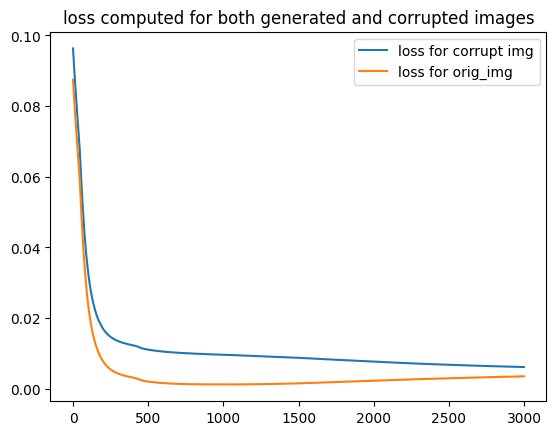

In [ ]:
import matplotlib.pyplot as plt

plt.plot(corrupt_loss_arr, label = 'loss for corrupt img')
plt.plot(loss_arr, label = 'loss for orig_img')
plt.title('loss computed for both generated and corrupted images')
plt.legend()

plt.show()

At this lr=0.001, the values on the loss function for the original image were greater than those for the damaged image
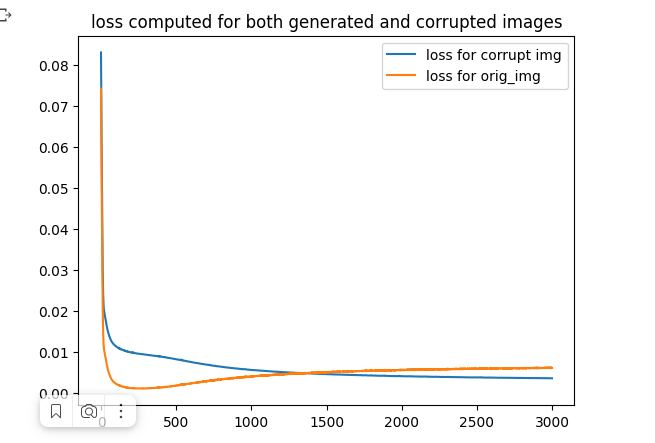

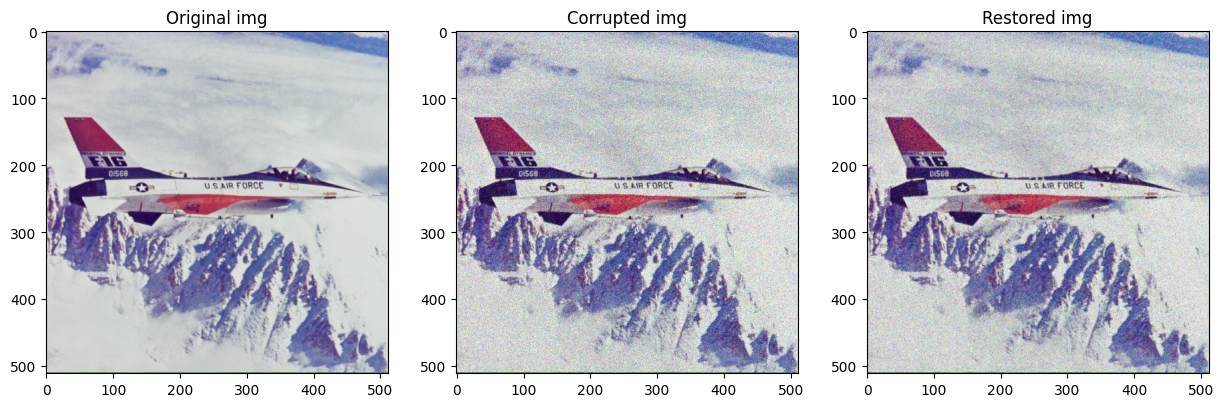

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

img2 = img.cpu().numpy()[0]
#convert image back to Height,Width,Channels
img2 = np.transpose(img2, (1,2,0))
ax1.set_title("Original img")

corrupted_img2 = corrupted_img.cpu().numpy()[0]
corrupted_img2 = np.transpose(corrupted_img2, (1,2,0))
ax2.set_title("Corrupted img")

outputs2 = outputs[0].detach().permute(1, 2, 0).cpu()
ax3.set_title("Restored img")

#show the image
ax1.imshow(img2)
ax2.imshow(corrupted_img2)
ax3.imshow(outputs2)
plt.show()

**Conclusion:** As we can see that the amount of noise in the restored image has decreased. However, the image has become more blurred. This is probably due to overfitting, which can be seen in the graphs above

## Early stopping (3 pts)

One solution to prevent the recurrence of past issues is by terminating the training process at an optimal point. However, determining the ideal number of iterations can be a challenging task. Therefore, your objective is to:

1. Find out appropriate number of iterations (the best reconstruction of original image)
2. Suggest stopping criteria for the denoising task in real case (when you do not know ground truth) (**Hint: use Total Variation metric to measure the amount of noise in the image**)
3. Compare the result of your strategy with found number of iterations in the first step

In [ ]:
# your code is here, find out appropriate number of iterations
min_number_iters = loss_arr.index(min(loss_arr))
print('appropriate number of iterations:', min_number_iters)

appropriate number of iterations: 1006


In [13]:
from torchmetrics import TotalVariation

In [14]:
def optimization_modified(model,z,noised_img,orig_img,iters,criterion=torch.nn.MSELoss(),reg_noise=0.01):
    model.train()
    #duplicate your previous code and stop optimization according to stopping criteria
    optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
    corrupt_loss_arr, loss_arr = [], []
    
    tv_arr = []

    for i in tqdm(range(iters)):

      Z_noise = z + torch.randn_like(z)*reg_noise
      optimizer.zero_grad()
      outputs = model(Z_noise)

      tv = TotalVariation().to(device)
      tv_value = tv(outputs).item()
      tv_arr.append(tv_value)

      loss = criterion(outputs, orig_img)
      corrupt_loss = criterion(outputs, corrupted_img)
      corrupt_loss.backward()
      optimizer.step()

      corrupt_loss_arr.append(corrupt_loss.item())
      loss_arr.append(loss.item())

    return outputs, corrupt_loss_arr, loss_arr, tv_arr

In [ ]:
model = Unet(inc=32, outc=3, hidden_size=16).to(device)
input = torch.normal(0, 0.1, (1, 32, img.size(2), img.size(3))).to(device)
optim_outputs, optim_corrupt_loss_arr, optim_loss_arr, tv_arr = optimization_modified(model,input,corrupted_img,img, 3000)

100%|██████████| 3000/3000 [02:15<00:00, 22.11it/s]


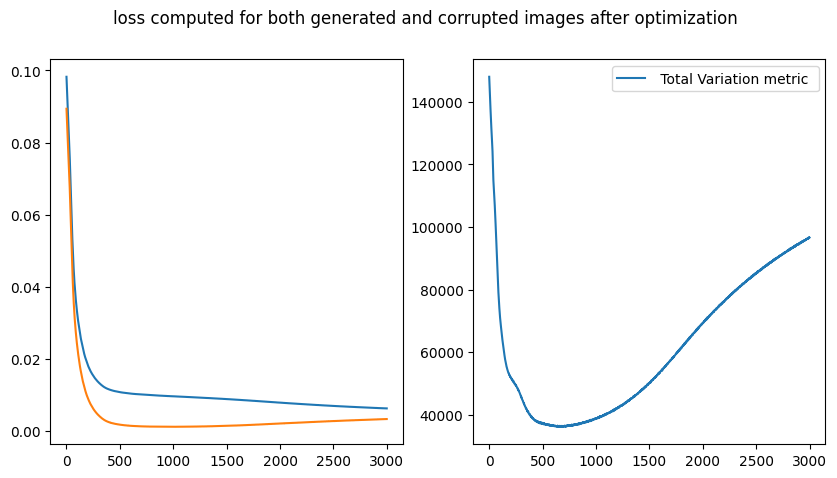

In [ ]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('loss computed for both generated and corrupted images after optimization')
ax1.plot(optim_corrupt_loss_arr, label = 'loss for corrupt img')
ax1.plot(optim_loss_arr, label = 'loss for orig_img')
ax2.plot(tv_arr, label = ' Total Variation metric ')
plt.legend()

plt.show()

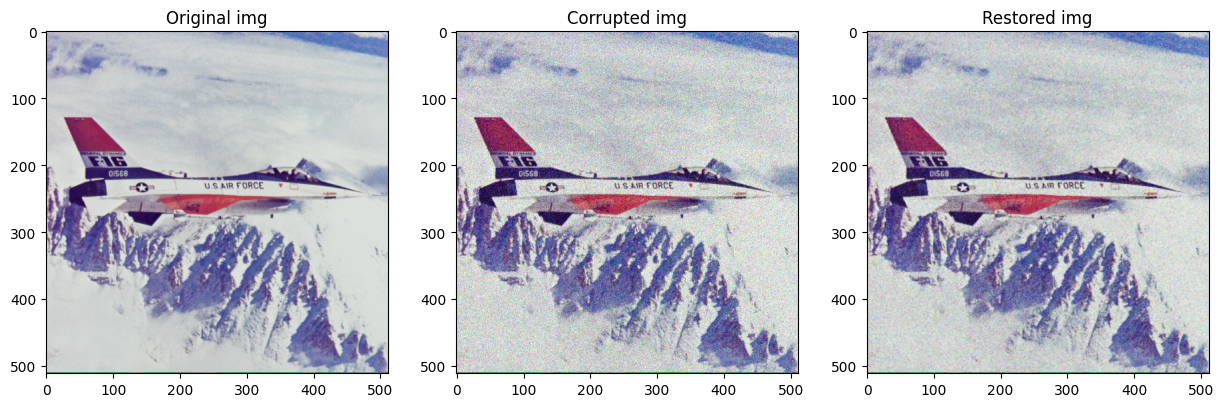

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

img2 = img.cpu().numpy()[0]
#convert image back to Height,Width,Channels
img2 = np.transpose(img2, (1,2,0))
ax1.set_title("Original img")

corrupted_img2 = corrupted_img.cpu().numpy()[0]
corrupted_img2 = np.transpose(corrupted_img2, (1,2,0))
ax2.set_title("Corrupted img")

outputs2 = optim_outputs[0].detach().permute(1, 2, 0).cpu()
ax3.set_title("Restored img")

#show the image
ax1.imshow(img2)
ax2.imshow(corrupted_img2)
ax3.imshow(outputs2)
plt.show()

Total Variation metric to measure the amount of noise in the image

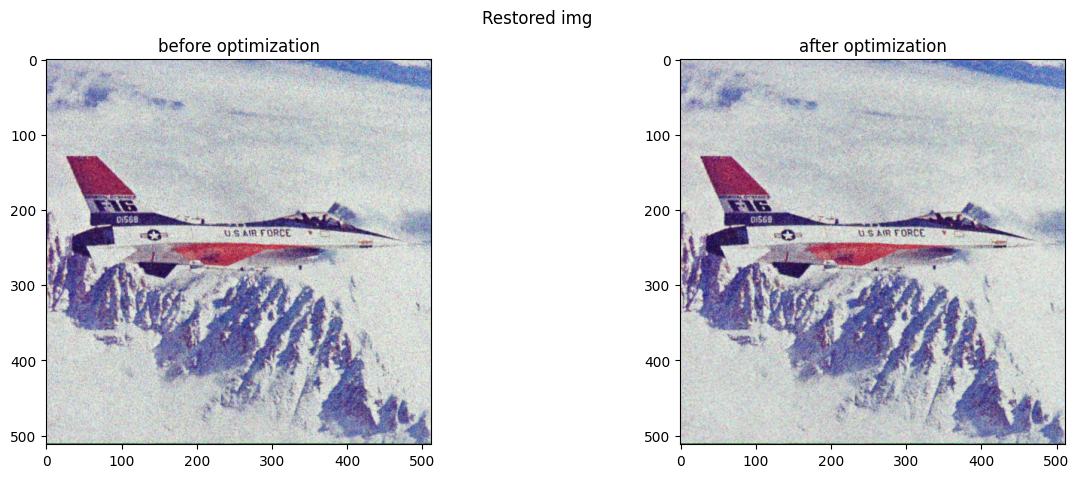

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))


outputs2 = outputs[0].detach().permute(1, 2, 0).cpu()
ax1.set_title("before optimization")

outputs3 = optim_outputs[0].detach().permute(1, 2, 0).cpu()
ax2.set_title("after optimization")

fig.suptitle('Restored img')
#show the image
ax1.imshow(outputs2)
ax2.imshow(outputs3)

plt.show()

In [ ]:
print('Total Variation metric to measure the amount of noise in the image:')
tv = TotalVariation().to(device)
print('before optimization:', tv(outputs).item())
print('after optimization:', tv(optim_outputs).item())

Total Variation metric to measure the amount of noise in the image:
before optimization: 99918.0078125
after optimization: 96620.484375


In [ ]:
min_number_iters = loss_arr.index(min(loss_arr))
optim_min_number_iters = tv_arr.index(min(tv_arr))
print('appropriate number of iterations by loss_original img:', min_number_iters)
print('appropriate number of iterations by tv metric:', optim_min_number_iters)

appropriate number of iterations by loss_original img: 1006
appropriate number of iterations by tv metric: 648


As we can see, the tv function stops the learning process much earlier than the minimum loss. However, in terms of the amount of noise in the image, the difference between the two is not great. As a result, it is possible to use both of these methods to pre-stop the learning process.

## Stochastic gradient Langevin dynamics (SGLD) optimization 

Another way to solve the problem of increasing the loss function over iterations is to adopt optimization procedure. In the explanations above we have already mentioned that the goal of deep prior is to evaluate the integral:

$$p(y|\hat{y}) = \int p(y|z,\theta,\hat{y})p(\theta|\hat{y})p(z)dzd\theta$$

Instead of directly solving the integral, we can use the Markov chain Monte Carlo (MCMC) method to estimate the posterior. This involves generating a sequence of correlated samples from the target distribution, which can converge to the true posterior during iterations. However, the MCMC approach can be slow and inefficient, and hence, using gradient-based optimization with noise can be a more effective solution. This involves minimizing the objective function and introducing noise to the gradient updates:

$$\theta_{i+1} = \theta_{i} + \mathrm{lr}\cdot\Delta_{i}^{\mathrm{standard}} + s\cdot\mathrm{lr}\cdot\epsilon$$

where $\Delta_{i}^{\mathrm{standard}}$ standard optimization update, $\mathrm{lr}$ - learning rate, $\epsilon \sim N(0,1)$, $s$ - strength of added noise.

More details of how and why it works described in [paper](https://arxiv.org/pdf/1904.07457.pdf)

### Implement SGLD (5 pts)

1. Take the previous implementation of the optimization procedure and adjust it to add noise to the model parameters after each iteration, but **only for convolutional layers**.
2. Set the strength of added noise to 4.
3. Plot the training convergence with the loss computed for generated and corrupted images.
4. Plot the training convergence with the loss computed for generated and original images.
5. Analyze and explain the results in comparison to the Early Stopping approach.
6. Try different values for the strength of added noise $s$ and comment the results.

In [12]:
def SGLD(model,z,corrupted_img,orig_img,iters,criterion=torch.nn.MSELoss(),strength = 4):
    # your code is here
    reg_noise=0.01
    lr=0.0001
    model.train()

    optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
    corrupt_loss_arr, loss_arr = [], []

    for i in tqdm(range(iters)):
      Z_noise = z + torch.randn_like(z)*reg_noise
      optimizer.zero_grad()
      outputs = model(Z_noise)

      loss = criterion(outputs, orig_img)
      corrupt_loss = criterion(outputs, corrupted_img)
      corrupt_loss.backward()
      optimizer.step()
      
      for param in model.parameters():
        if len(param.size()) == 4:
          param.data += strength * lr * torch.randn_like(param)

      corrupt_loss_arr.append(corrupt_loss.item())
      loss_arr.append(loss.item())

    return outputs, corrupt_loss_arr, loss_arr

In [ ]:
model = Unet(inc=32, outc=3, hidden_size=16).to(device)
input = torch.normal(0, 0.1, (1, 32, img.size(2), img.size(3))).to(device)
SGLD_outputs, SGLD_corrupt_loss_arr, SGLD_loss_arr= SGLD(model,input,corrupted_img,img, 3000)

100%|██████████| 3000/3000 [02:13<00:00, 22.44it/s]


In [14]:
input = torch.normal(0, 0.1, (1, 32, img.size(2), img.size(3))).to(device)

100%|██████████| 3000/3000 [02:12<00:00, 22.62it/s]


--------------Noise_strength=0.05-----------
Optimal number of iterations = 869
Total Variation metric = 100880.203125


100%|██████████| 3000/3000 [02:12<00:00, 22.71it/s]


--------------Noise_strength=1-----------
Optimal number of iterations = 1286
Total Variation metric = 94268.875


100%|██████████| 3000/3000 [02:12<00:00, 22.70it/s]


--------------Noise_strength=6-----------
Optimal number of iterations = 2961
Total Variation metric = 33162.26953125


100%|██████████| 3000/3000 [02:12<00:00, 22.72it/s]


--------------Noise_strength=10-----------
Optimal number of iterations = 2975
Total Variation metric = 31644.25


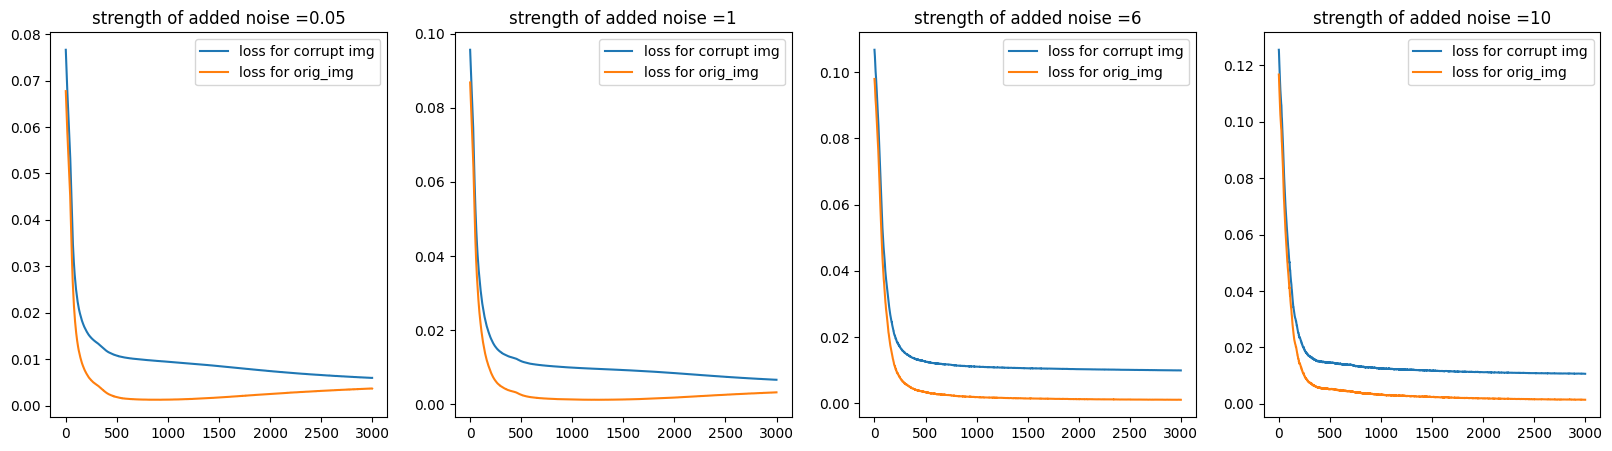

In [18]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
strength = [0.05,1,6,10]
for i in range(len(strength)):
  model = Unet(inc=32,outc=3,hidden_size=16).to(device)
  SGLD_outputs_i, SGLD_corrupt_loss_arr_i, SGLD_loss_arr_i= SGLD(model,input,corrupted_img,img, 3000, strength = strength[i])

  min_number_iters = SGLD_loss_arr_i.index(min(SGLD_loss_arr_i))
  tv = TotalVariation().to(device)
  tv_value = tv(SGLD_outputs_i).item()

  ax[i].plot(SGLD_corrupt_loss_arr_i, label = 'loss for corrupt img')
  ax[i].plot(SGLD_loss_arr_i, label = 'loss for orig_img')
  ax[i].set_title('strength of added noise ={}'.format(strength[i]))
  ax[i].legend()
  print(f"--------------Noise_strength={strength[i]}-----------")
  print(f"Optimal number of iterations =", min_number_iters)
  print(f"Total Variation metric =", tv_value)

100%|██████████| 3000/3000 [02:12<00:00, 22.57it/s]


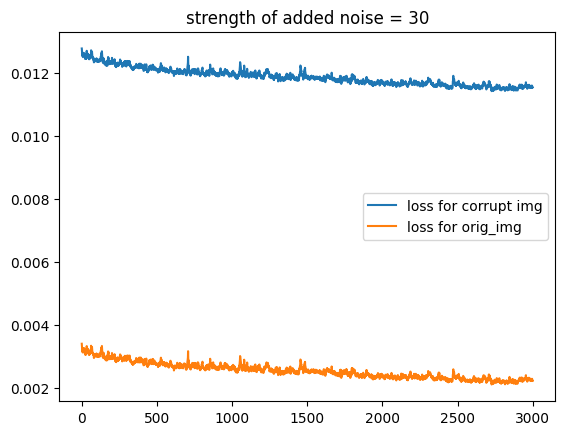

Optimal number of iterations = 2726
Total Variation metric = 36516.09375


In [20]:
SGLD_outputs, SGLD_corrupt_loss_arr, SGLD_loss_arr= SGLD(model,input,corrupted_img,img, 3000, strength = 30)
plt.plot(SGLD_corrupt_loss_arr, label = 'loss for corrupt img')
plt.plot(SGLD_loss_arr, label = 'loss for orig_img')
plt.title('strength of added noise = 30')
plt.legend()

plt.show()

min_number_iters = SGLD_loss_arr.index(min(SGLD_loss_arr))
tv = TotalVariation().to(device)
tv_value = tv(SGLD_outputs).item()
print(f"Optimal number of iterations =", min_number_iters)
print(f"Total Variation metric =", tv_value)

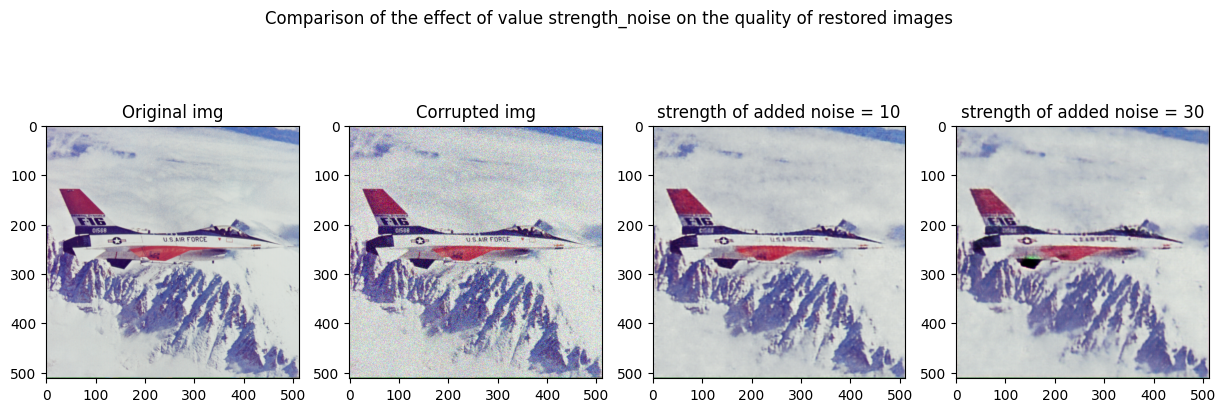

In [24]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 5))

img2 = img.cpu().numpy()[0]
#convert image back to Height,Width,Channels
img2 = np.transpose(img2, (1,2,0))
ax1.set_title("Original img")

corrupted_img2 = corrupted_img.cpu().numpy()[0]
corrupted_img2 = np.transpose(corrupted_img2, (1,2,0))
ax2.set_title("Corrupted img")

outputs2 = SGLD_outputs_i[0].detach().permute(1, 2, 0).cpu()
ax3.set_title("strength of added noise = 10")

outputs3 = SGLD_outputs[0].detach().permute(1, 2, 0).cpu()
ax4.set_title("strength of added noise = 30")

fig.suptitle('Comparison of the effect of value strength_noise on the quality of restored images')
#show the image
ax1.imshow(img2)
ax2.imshow(corrupted_img2)
ax3.imshow(outputs2)
ax4.imshow(outputs3)

plt.show()

**Conclusion:** We can see that the restored image has optimum quality in the region of values strength_noise = 10. When this value is increased, the total Variation metric does not decrease, but there is a loss of detail in the image. If the value is too low, overfitting occurs at later epochs

## Inpainting

Deep Image Prior is a versatile tool that can be utilized in solving an important task such as image inpainting. In this task, the challenge lies in the inability to obtain values for the pixels that are damaged and defined by the mask. Thus, during the training process, it is essential to apply the mask to the generated image as these values are unavailable for this particular task. Furthermore, in order to effectively address this issue, you will try a more complex model called AttentionUNet. This model is similar to the UNet model in terms of structure but with the inclusion of attention blocks in the decoder part. 

### Attention block (10 pts)

For AttentionUNet implementation you only need to implement Attention layer. Attention should scale hidden output of encoder block which is also an input for the corresponding decoder block in order to draw more "attention" to particular image parts. Below we have placed the pipeline which you should implement:

**Input:** $skip$ of size [batch,skip_channels,H_skip,W_skip], $x$ of size [batch,x_channels,H_x,W_x]

**Output:** $skip^*$ of size [batch,skip_channels,H_skip,W_skip]

1. Apply 2d convolution with kernel size $2$ to $skip$ to make it of size [batch,skip_channels,H_x,W_x] (recall that 2H_x = H_skip, 2W_x = W_skip)
2. Apply 2d convolution with kernel size $1$ to $x$ to make it of size [batch,skip_channels,H_x,W_x]
3. Sum the outputs of previous two steps and apply ReLU over it.
4. Apply 2d convolution to previous output to reduce channel dimension to 1. So the output should have size equal [batch,1,H_x,W_x]
5. Apply Sigmoid to the previous output to get attention itself
6. Apply attention to the input $skip$ (original block input **NOT** the output of the first step) by simply multipling $skip$ by attention element-wise.

In [15]:
class Attention(torch.nn.Module):
    def __init__(self,skip_channels, x_channels):
        super().__init__()
        # your code is here
        self.conv1 =  torch.nn.Conv2d(skip_channels,skip_channels,kernel_size=2,stride=2)
        self.conv2 =  torch.nn.Conv2d(x_channels,skip_channels,kernel_size=1)
        self.relu = torch.nn.ReLU()
        self.conv3 =  torch.nn.Conv2d(skip_channels,1,kernel_size=1)
        self.sigmoid = torch.nn.Sigmoid()
        self.upsampling = torch.nn.Upsample(scale_factor=2, mode='nearest')
        
    def forward(self,skip,x):
        # your code is here
        out = self.relu(self.conv1(skip) + self.conv2(x))
        out = self.sigmoid(self.conv3(out))
        out = self.upsampling(out)
        return skip * out 

In [16]:
class Decoder_Block_With_Attention(torch.nn.Module):
    def __init__(self,inp_channels,out_channels):
        super().__init__()
        self.upsample = torch.nn.ConvTranspose2d(inp_channels,out_channels,kernel_size=2,stride=2)
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(inp_channels,out_channels,kernel_size=3,padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
        )
        self.attention = Attention(out_channels,inp_channels)
    def forward(self,x,enc_x):
        enc_x = self.attention(enc_x,x)
        x = self.upsample(x)
        x = torch.cat([x,enc_x],dim=1)
        return self.model(x)


class AttentionUnet(torch.nn.Module):
    def __init__(self,inc,outc,hidden_size=16):
        super().__init__()
        self.Encoder = torch.nn.ModuleList([
            Encoder_Block(inc,hidden_size),
            Encoder_Block(hidden_size,hidden_size*2),
            Encoder_Block(hidden_size*2,hidden_size*4),
            Encoder_Block(hidden_size*4,hidden_size*8),
        ])
        self.bottleneck = torch.nn.Sequential(
            torch.nn.Conv2d(hidden_size*8,hidden_size*16,kernel_size=1),
            torch.nn.BatchNorm2d(hidden_size*16),
            torch.nn.ReLU(),
            torch.nn.Conv2d(hidden_size*16,hidden_size*16,kernel_size=1),
            torch.nn.BatchNorm2d(hidden_size*16),
            torch.nn.ReLU()
        )
        self.Decoder = torch.nn.ModuleList([
            Decoder_Block_With_Attention(hidden_size*16,hidden_size*8),
            Decoder_Block_With_Attention(hidden_size*8,hidden_size*4),
            Decoder_Block_With_Attention(hidden_size*4,hidden_size*2),
            Decoder_Block_With_Attention(hidden_size*2,hidden_size*1),
        ])
        self.last_layer = torch.nn.Sequential(
            torch.nn.Conv2d(hidden_size,outc,kernel_size=3,padding="same"),
            torch.nn.Sigmoid()
        )
    def forward(self,x):
        enc_xs = []
        for module in self.Encoder:
            x, enc_x= module(x)
            enc_xs.append(enc_x)

        enc_xs = enc_xs[::-1]
        x = self.bottleneck(x)

        for i,module in enumerate(self.Decoder):
            x = module(x,enc_xs[i])
        return self.last_layer(x)

In [17]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor()
])

In [18]:
img = transform(Image.open("./data/inpainting/library.png"))[None].to(device)
img_mask = transform(Image.open("./data/inpainting/library_mask.png"))[None].to(device)
corrupted_img = img * img_mask

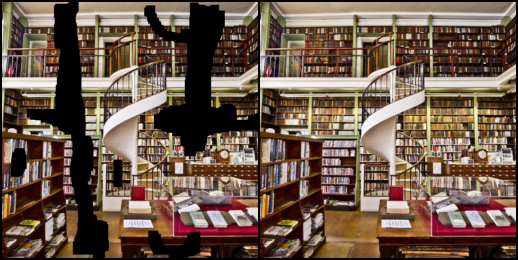

In [19]:
transforms.ToPILImage()(torchvision.utils.make_grid(torch.cat([corrupted_img,img],dim=0),nrow=2,normalize=True))

### Modify SGLD optimization (6 pts):
1. Take the code for SGLD and update loss calculation by applying mask to generated image (take $s$ = 4, lr = $4 \cdot 10^{-4}$, reg_noise = $0.2$, iters=$2000$)
2. Run the code and evaluate how well model fitted to known pixels and restore the missed one
3. Run the same code with standard UNet model and compare results with AttentionUNet. What conclusion can you make?


**Bonus task (4 pts)** Try to find optimal hyper parameters (strength of added noise $s$, learning rate, reg_noise, number of iterations)

In [29]:
def optimization_inpainting(model,z,corrupted_img,orig_img,mask,iters,criterion=torch.nn.MSELoss(),reg_noise=0.2,lr=0.0004,noise_strength=4):
    #your code is here
    model.train()
    loss_corrupted_arr, loss_orig_arr = [], []
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for i in tqdm(range(iters)):
      optimizer.zero_grad() 
      Z_noisy = z + reg_noise * torch.randn_like(z)
      output = model(Z_noisy)

      loss_orig = criterion(output, orig_img)
      loss_corrupted = criterion(output * mask, corrupted_img)
      loss_corrupted.backward()
      optimizer.step()
      
      for param in model.parameters():
        if len(param.size()) == 4:
          param.data += noise_strength * lr * torch.randn_like(param)
      
      loss_corrupted_arr.append(loss_corrupted.item())
      loss_orig_arr.append(loss_orig.item())
    return output, loss_corrupted_arr, loss_orig_arr

In [21]:
nc = 2
model_without_attention = Unet(nc,3,hidden_size=16).to(device)
z = torch.cat(torch.meshgrid(torch.arange(img.size(2))/img.size(2),torch.arange(img.size(3))/img.size(3))).reshape(1,2,img.size(2),img.size(3)).to(device)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [26]:
# your code is here
output_without, loss_corrupted_array_without, loss_orig_array_without = optimization_inpainting(model_without_attention,z,corrupted_img,img,img_mask,iters = 2000)

100%|██████████| 2000/2000 [00:25<00:00, 77.48it/s]


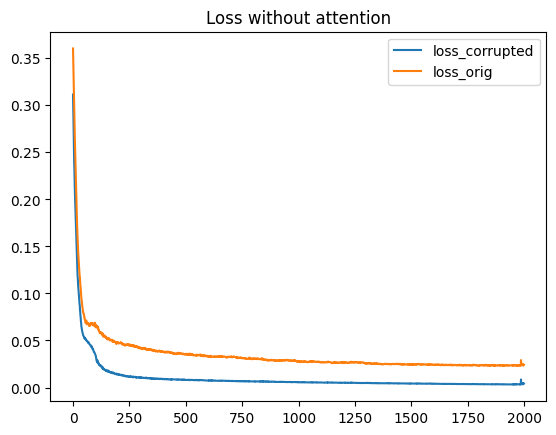

In [27]:
plt.plot(loss_corrupted_array_without, label="loss_corrupted")
plt.plot(loss_orig_array_without, label="loss_orig")
plt.title("Loss without attention")
plt.legend();

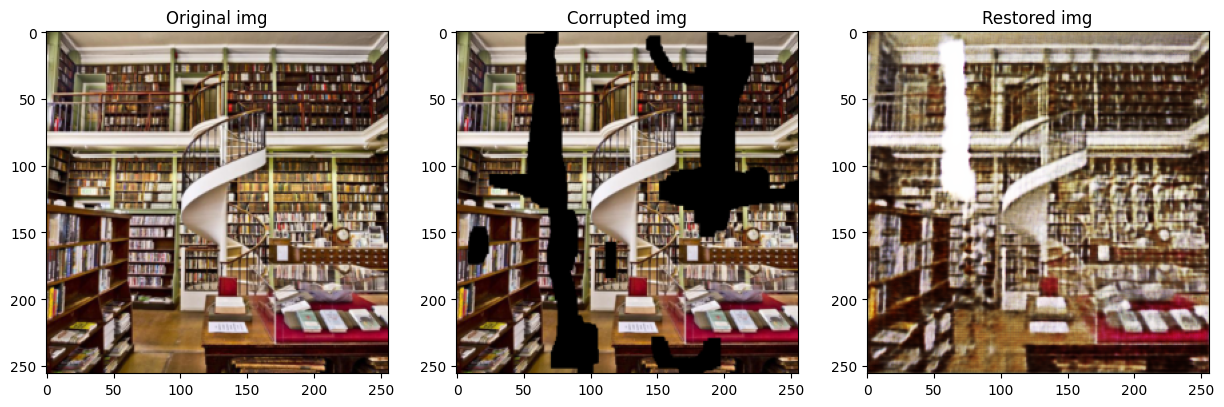

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.imshow(img[0].permute(1, 2, 0).cpu())
ax1.set_title("Original img")

ax2.imshow(corrupted_img[0].permute(1, 2, 0).cpu())
ax2.set_title("Corrupted img")

ax3.imshow(output_without[0].detach().permute(1, 2, 0).cpu())
ax3.set_title("Restored img");

In [79]:
nc = 2
model_with_attention = AttentionUnet(nc,3,hidden_size=16).to(device)
z = torch.cat(torch.meshgrid(torch.arange(img.size(2))/img.size(2),torch.arange(img.size(3))/img.size(3))).reshape(1,2,img.size(2),img.size(3)).to(device)

In [80]:
output_with, loss_corrupted_array_with, loss_orig_array_with = optimization_inpainting(model_with_attention,z,corrupted_img,img,img_mask)

100%|██████████| 2000/2000 [00:36<00:00, 54.93it/s]


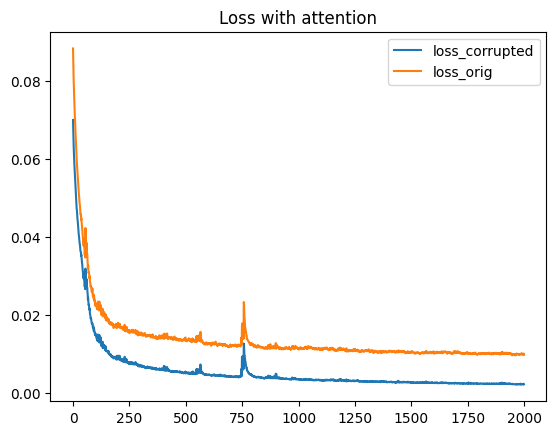

In [81]:
plt.plot(loss_corrupted_array_with, label="loss_corrupted")
plt.plot(loss_orig_array_with, label="loss_orig")
plt.title("Loss with attention")
plt.legend();

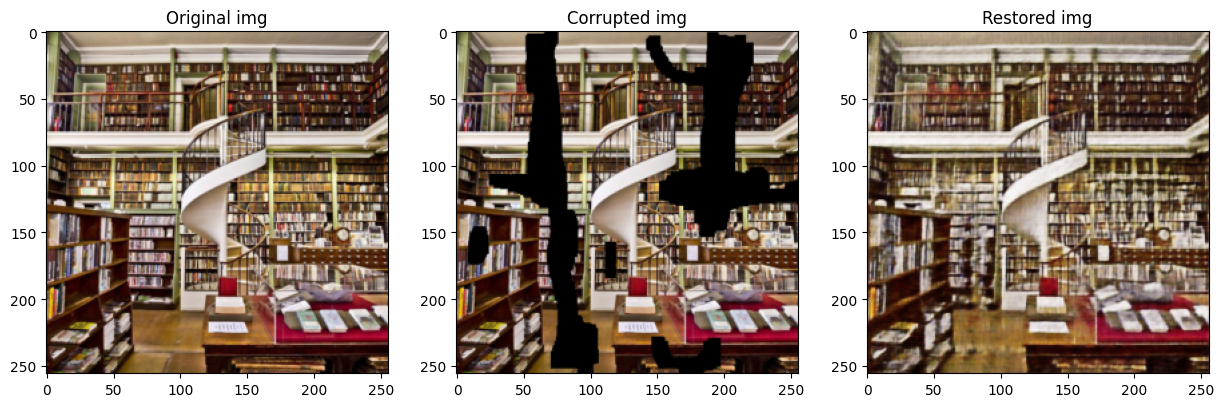

In [83]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

img1 = img.cpu().numpy()[0]
img2 = np.transpose(img1, (1,2,0))
ax1.imshow(img2)
ax1.set_title("Original img")

corrupted_img1 = corrupted_img.cpu().numpy()[0]
corrupted_img2 = np.transpose(corrupted_img1, (1,2,0))
ax2.imshow(corrupted_img2)
ax2.set_title("Corrupted img")

ax3.imshow(output_with[0].detach().permute(1, 2, 0).cpu())
ax3.set_title("Restored img");

**Conclusion:** You can see that the without_attention model will replace missing values with nearby elements, which is very much out of place in the overall picture. Thus, the cabinets look much more correctly In the with_attention picture. The attention block improves the verisimilitude of the picture, but if you look more closely, the objects will look chaotic. We can conclude that AttentionUNet does a much better job of adding a mask.